In [ ]:
%%capture
# 한글 폰트 설치 및 리눅스 시스템 캐시 업데이트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# 폰트 및 스타일 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

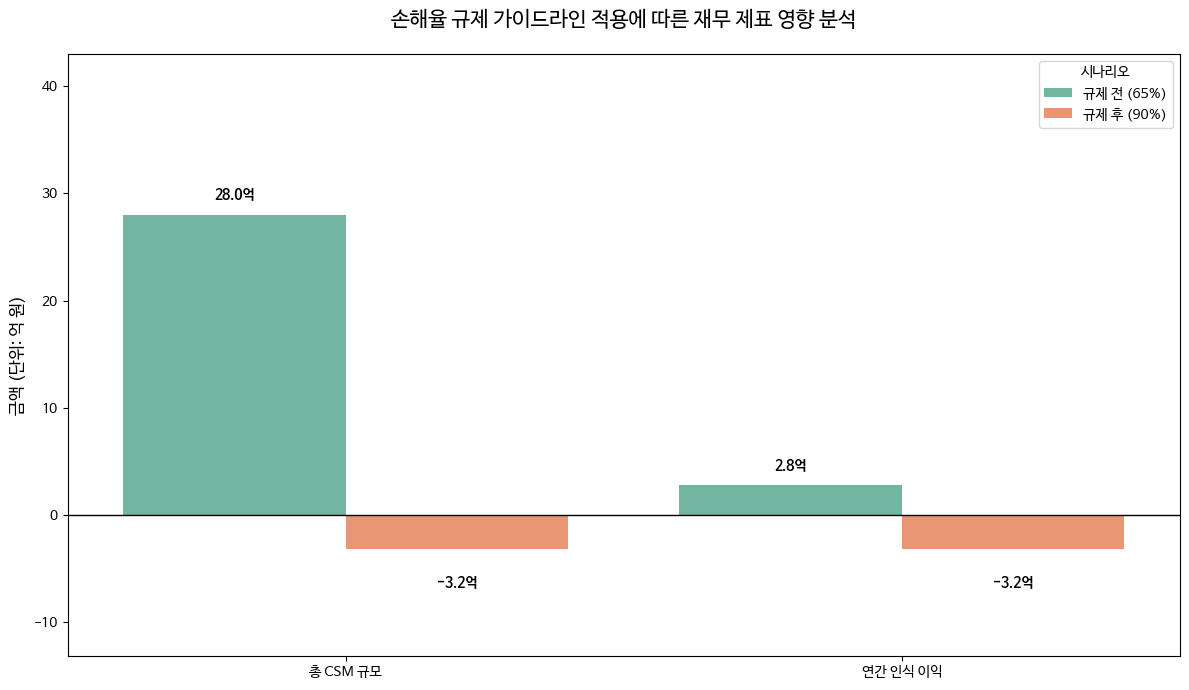

■ CSM 총액 변동: 28.0억 → -3.2억
■ 연간 이익 변동: 2.8억 → -3.2억


In [ ]:
# 1. 데이터 로드
df = pd.read_csv('insurance_sim_data.csv')

# 2. IFRS17 재무 시뮬레이션 로직
# CSM 상각률 10% 가정 및 손실부담금(마이너스 CSM) 즉시 비용 처리
AMORT_RATE = 0.1
df['Immediate_Loss'] = df['CSM_New'].apply(lambda x: abs(x) if x < 0 else 0)
df['Current_Profit_Old'] = df['CSM_Old'] * AMORT_RATE
df['Current_Profit_New'] = df['CSM_New'].apply(lambda x: x * AMORT_RATE if x > 0 else 0) - df['Immediate_Loss']

# 3. 시각화 데이터 생성 (단위: 억 원)
UNIT = 1e8
summary_data = {
    '구분': ['총 CSM 규모', '연간 인식 이익'],
    '규제 전 (65%)': [df['CSM_Old'].sum() / UNIT, df['Current_Profit_Old'].sum() / UNIT],
    '규제 후 (90%)': [df['CSM_New'].sum() / UNIT, df['Current_Profit_New'].sum() / UNIT]
}
summary_df = pd.DataFrame(summary_data)
melted_df = summary_df.melt(id_vars='구분', var_name='시나리오', value_name='금액')

# 4. 시각화 실행
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=melted_df, x='구분', y='금액', hue='시나리오', palette='Set2')

# 레이아웃 및 축 설정
plt.title('손해율 규제 가이드라인 적용에 따른 재무 제표 영향 분석', fontsize=15, pad=20)
plt.ylabel('금액 (단위: 억 원)', fontsize=12)
plt.xlabel('')
plt.axhline(0, color='black', linewidth=1)

# Y축 콤마 포맷팅 및 범위 최적화
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(melted_df['금액'].min() - 10, melted_df['금액'].max() + 15)

# 5. 데이터 라벨링 (0.0억 유령 라벨 제거 로직)
for p in ax.patches:
    val = p.get_height()
    # 절대값이 0.1억 미만인 수치는 라벨을 출력하지 않음
    if not np.isnan(val) and abs(val) > 0.1:
        ax.text(p.get_x() + p.get_width()/2., val + (1.5 if val > 0 else -3.5),
                f'{val:,.1f}억', ha="center", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 주요 재무 지표 요약 출력
print(f"■ CSM 총액 변동: {summary_df.iloc[0,1]:,.1f}억 → {summary_df.iloc[0,2]:,.1f}억")
print(f"■ 연간 이익 변동: {summary_df.iloc[1,1]:,.1f}억 → {summary_df.iloc[1,2]:,.1f}억")